# Actividad 3.1 Detección de Peatones
### Equipo7

# Se cargan las bibliotecas necesarias

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog

from skimage.transform import resize # Para asegurar el tamaño de las imágenes

# Se importan los dos datasets 
### https://www.kaggle.com/datasets/adityasinghz/pedestrian-detection-dataset?resource=download

In [2]:
import glob
pedestrian = glob.glob("data_svm/Positive/*.jpg")
no_pedestrian = glob.glob("data_svm/Negative/*.jpg")

In [3]:
len(pedestrian)

3263

In [4]:
len(no_pedestrian)

3266

# Se muestra una imagen con peatón

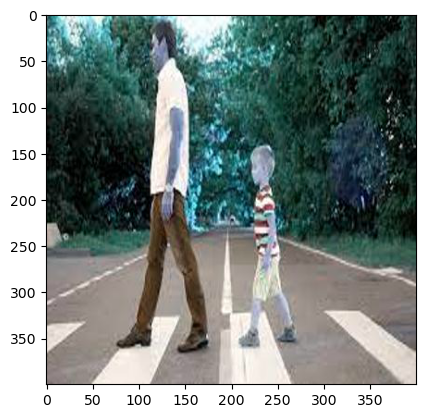

In [5]:
img_color = cv2.imread(pedestrian[889])
plt.imshow(img_color)

# Para fines de demostración se calcula el HOG de la imagen

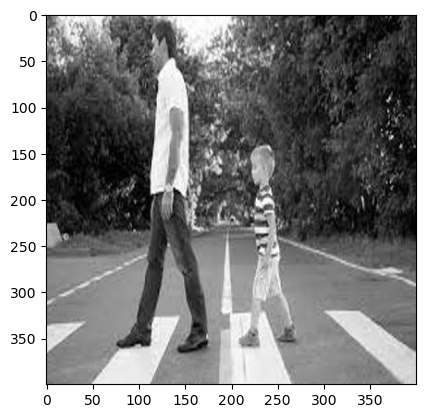

In [6]:
img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap="gray")

In [7]:
img_gray = resize(img_gray, (100,100)) # para asegurar que todas las imágenes tengan el mismo tamaño
features,hog_img = hog(img_gray,
                       orientations = 8, # se reduce el número de orientaciones
                       pixels_per_cell = (16,16), # se mantienen celdas pequeñas para capturar los detalles
                       cells_per_block = (4,4), # se aumenta por tratar con imágenes más grandes
                       transform_sqrt = False,
                       visualize = True,
                       feature_vector = True)

In [8]:
features.shape

(1152,)

In [9]:
hog_img.shape

(100, 100)

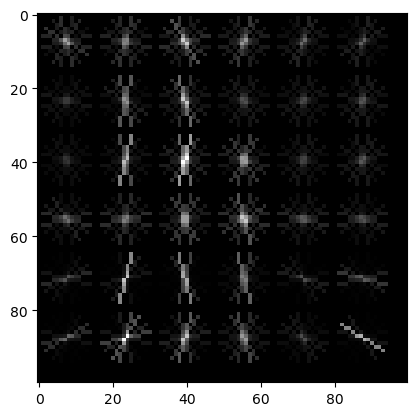

In [10]:
plt.imshow(hog_img,cmap = 'gray')

# Se extraen las features del HOG para ambos tipos de datos

In [11]:
pedestrian_hog_accum = []

for i in pedestrian:
    img_color = cv2.imread(i) # se cambia mpimg a cv2 porque se trabaja con imágenes jpg
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    img_gray = resize(img_gray, (100,100)) # para asegurar que todas las imágenes tengan el mismo tamaño
    
    pedestrian_hog_feature, pedestrian_hog_img = hog(img_gray,
                                           orientations = 8, # se reduce el número de orientaciones
                                           pixels_per_cell = (16,16), # se mantienen celdas pequeñas para capturar los detalles
                                           cells_per_block = (4,4), # se aumenta por tratar con imágenes más grandes
                                           transform_sqrt = False,
                                           visualize = True,
                                           feature_vector = True)
    
    pedestrian_hog_accum.append(pedestrian_hog_feature)

In [12]:
X_pedestrian = np.vstack(pedestrian_hog_accum).astype(np.float64)
y_pedestrian = np.ones(len(X_pedestrian))

In [13]:
X_pedestrian.shape

(3263, 1152)

In [14]:
y_pedestrian.shape

(3263,)

In [15]:
nopedestrian_hog_accum = []

for i in no_pedestrian:
    img_color = cv2.imread(i) # se cambia mpimg a cv2 porque se trabaja con imágenes jpg
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    img_gray = resize(img_gray, (100,100)) # para asegurar que todas las imágenes tengan el mismo tamaño
    
    nopedestrian_hog_feature, nopedestrian_hog_img = hog(img_gray,
                                               orientations = 8, # se reduce el número de orientaciones
                                               pixels_per_cell = (16,16), # se mantienen celdas pequeñas para capturar los detalles
                                               cells_per_block = (4,4), # se aumenta por tratar con imágenes más grandes
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    nopedestrian_hog_accum.append(nopedestrian_hog_feature)

In [16]:
X_nopedestrian = np.vstack(nopedestrian_hog_accum).astype(np.float64)
y_nopedestrian = np.zeros(len(X_nopedestrian))

In [17]:
X_nopedestrian.shape

(3266, 1152)

In [18]:
y_nopedestrian.shape

(3266,)

# Se combinan ambos tipos de datos para alimentar el SVM

In [19]:
X = np.vstack((X_pedestrian,X_nopedestrian))
X.shape

(6529, 1152)

In [20]:
y = np.hstack((y_pedestrian,y_nopedestrian))
y.shape

(6529,)

# Se generan los datos de entrenamiento y de prueba

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [22]:
X_train.shape

(4570, 1152)

In [23]:
X_test.shape

(1959, 1152)

# Se importa el Clasificador y se entrena

In [24]:
#from sklearn.svm import LinearSVC

#svc_model = LinearSVC()
#svc_model.fit(X_train, y_train)
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)

SVC()

In [25]:
y_predict = svc_model.predict(X_test)

<Axes: >

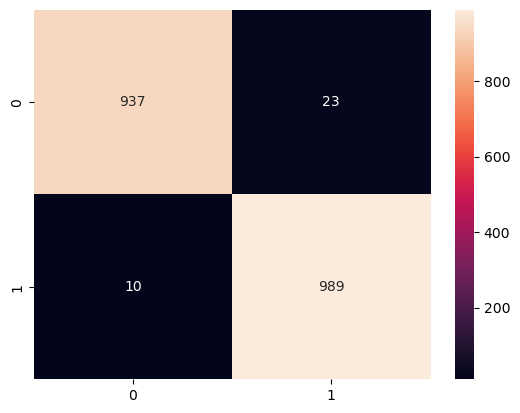

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot=True, fmt = "d")

In [27]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       960
         1.0       0.98      0.99      0.98       999

    accuracy                           0.98      1959
   macro avg       0.98      0.98      0.98      1959
weighted avg       0.98      0.98      0.98      1959



# GridSearchCV

In [28]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [29]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.953 total time=  45.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.958 total time=  44.8s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.950 total time=  45.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.961 total time=  45.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=  45.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.974 total time=  16.9s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.982 total time=  17.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.974 total time=  17.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.982 total time=  16.9s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.970 total time=  17.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.956 total time=  35.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

In [30]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [31]:
grid.best_estimator_

SVC(C=10, gamma=0.1)

In [32]:
grid_predictions = grid.predict(X_test)

<Axes: >

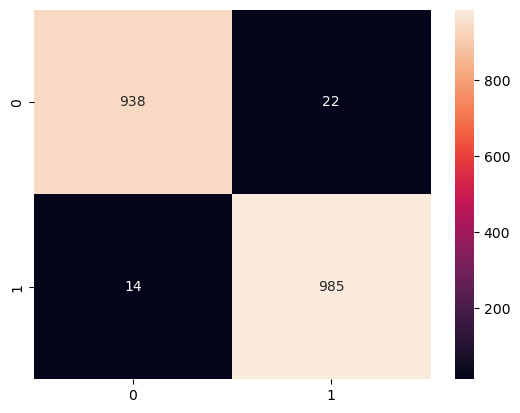

In [33]:
cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt = "d")

In [34]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       960
         1.0       0.98      0.99      0.98       999

    accuracy                           0.98      1959
   macro avg       0.98      0.98      0.98      1959
weighted avg       0.98      0.98      0.98      1959



# Gracias por la atención